Bayesian estimation with multivariate normal disributions
---------------------------------------------------------

Copyright 2016 Allen Downey

MIT License: http://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

import numpy as np
import pandas as pd
import scipy

from itertools import product, starmap

import thinkbayes2
import thinkplot

%matplotlib inline

This notebook contains a solution to [a problem posted on Reddit](https://www.reddit.com/r/statistics/comments/4csjee/finding_pab_given_two_sets_of_data/); here's the original statement of the problem:

>So, I have two sets of data where the elements correspond to each other:

    A = {122.8, 115.5, 102.5, 84.7, 154.2, 83.7, 122.1, 117.6, 98.1, 
         111.2, 80.3, 110.0, 117.6, 100.3, 107.8, 60.2}
    B = {82.6, 99.1, 74.6, 51.9, 62.3, 67.2, 82.4, 97.2, 68.9, 77.9,
         81.5, 87.4, 92.4, 80.8, 74.7, 42.1}

>I'm trying to find out the probability that (91.9 <= A <= 158.3) and (56.4 <= B <= 100).
I know that P(91.9 <= A <= 158.3) = 0.727098 and that P(56.4 <= B <= 100) = 0.840273, given that A is a normal distribution with mean 105.5 and standard deviation 21.7 and that B is a normal distribution with mean 76.4 and standard deviation 15.4. However, since they are dependent events, P(BA)=P(A)P(B|A)=P(B)P(A|B). Is there any way that I can find out P(A|B) and P(B|A) given the data that I have?

The original poster added this clarification:

>I'm going to give you some background on what I'm trying to do here first. I'm doing sports analysis trying to find the best quarterback of the 2015 NFL season using passer rating and quarterback rating, two different measures of how the quarterback performs during a game. The numbers in the sets above are the different ratings for each of the 16 games of the season (A being passer rating, B being quarterback rating, the first element being the first game, the second element being the second, etc.) The better game the quarterback has, the higher each of the two measures will be; I'm expecting that they're correlated and dependent on each other to some degree. I'm assuming that they're normally distributed because most things done by humans tend to be normally distributed.


As a first step, let's look at the data.  I'll put the two datasets into NumPy arrays.

In [2]:
a = np.array([122.8, 115.5, 102.5, 84.7, 154.2, 83.7,
              122.1, 117.6, 98.1, 111.2, 80.3, 110.0,
              117.6, 100.3, 107.8, 60.2])
b = np.array([82.6, 99.1, 74.6, 51.9, 62.3, 67.2,
              82.4, 97.2, 68.9, 77.9, 81.5, 87.4,
              92.4, 80.8, 74.7, 42.1])
n = len(a)
n

16

And make a scatter plot:

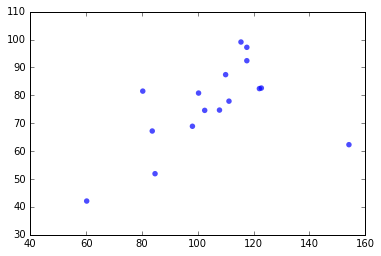

In [3]:
thinkplot.Scatter(a, b, alpha=0.7)

It looks like modeling this data with a bi-variate normal distribution is a reasonable choice.

Let's make an single array out of it:

In [4]:
X = np.array([a, b])

And compute the sample mean

In [5]:
xbar = X.mean(axis=1)
xbar

array([ 105.5375,   76.4375])

Sample standard deviation

In [6]:
std = X.std(axis=1)
std

array([ 21.04040384,  14.93640163])

Covariance matrix

In [7]:
S = np.cov(X)
S

array([[ 472.21183333,  161.33583333],
       [ 161.33583333,  237.96916667]])

And correlation coefficient

In [8]:
corrcoef = np.corrcoef(a, b)
corrcoef

array([[ 1.       ,  0.4812847],
       [ 0.4812847,  1.       ]])

Now, let's start thinking about this as a Bayesian estimation problem.

There are 5 parameters we would like to estimate: 

* The means of the two variables, μ_a, μ_b

* The standard deviations, σ_a, σ_b

* The coefficient of correlation, ρ.

As a simple starting place, I'll assume that the prior distributions for these variables are uniform over all possible values.

I'm going to use a mesh algorithm to compute the joint posterior distribution, so I'll "cheat" and construct the mesh using conventional estimates for the parameters.

For each parameter, I'll compute a range of possible values where

* The center of the range is the value estimated from the data.

* The width of the range is 6 standard errors of the estimate.

The likelihood of any point outside this mesh is so low, it's safe to ignore it.

Here's how I construct the ranges:

In [9]:
def make_array(center, stderr, m=11, factor=3):
    return np.linspace(center-factor*stderr, 
                       center+factor*stderr,
                       m)

μ_a = xbar[0]
μ_b = xbar[1]
σ_a = std[0]
σ_b = std[1]
ρ = corrcoef[0][1]

μ_a_array = make_array(μ_a, σ_a / np.sqrt(n))
μ_b_array = make_array(μ_b, σ_b / np.sqrt(n))
σ_a_array = make_array(σ_a, σ_a / np.sqrt(2 * (n-1)))
σ_b_array = make_array(σ_b, σ_b / np.sqrt(2 * (n-1)))
#ρ_array = make_array(ρ, np.sqrt((1 - ρ**2) / (n-2)))
ρ_array = make_array(ρ, 0.15)

def min_max(array):
    return min(array), max(array)

print(min_max(μ_a_array))
print(min_max(μ_b_array))
print(min_max(σ_a_array))
print(min_max(σ_b_array))
print(min_max(ρ_array))

(89.757197120005102, 121.31780287999489)
(65.235198775056304, 87.639801224943696)
(9.5161000378105989, 32.564707642175762)
(6.7553975307657055, 23.117405735750815)
(0.031284703359568844, 0.93128470335956881)


Although the mesh is constructed in 5 dimensions, for doing the Bayesian update, I want to express the parameters in terms of a vector of means, μ, and a covariance matrix, Σ.

`Params` is an object that encapsulates these values.  `pack` is a function that takes 5 parameters and returns a `Param` object.

In [10]:
class Params:
    def __init__(self, μ, Σ):
        self.μ = μ
        self.Σ = Σ
        
    def __lt__(self, other):
        return (self.μ, self.Σ) < (self.μ, self.Σ)

In [11]:
def pack(μ_a, μ_b, σ_a, σ_b, ρ):
    μ = np.array([μ_a, μ_b])
    cross = ρ * σ_a * σ_b
    Σ = np.array([[σ_a**2, cross], [cross, σ_b**2]])
    return Params(μ, Σ)

Now we can make a prior distribution.  First, `mesh` is the Cartesian product of the parameter arrays.  Since there are 5 dimensions with 11 points each, the total number of points is $11^5 = 161,051$.

In [12]:
mesh = product(μ_a_array, μ_b_array, 
               σ_a_array, σ_b_array, ρ_array)

The result is an iterator.  We can use `itertools.starmap` to apply `pack` to each of the points in the mesh: 

In [13]:
mesh = starmap(pack, mesh)

Now we need an object to encapsulate the mesh and perform the Bayesian update.  `MultiNorm` represents a map from each `Param` object to its probability.

It inherits `Update` from `thinkbayes2.Suite` and provides `Likelihood`, which computes the probability of the data given a hypothetical set of parameters.

If we know the mean is `μ` and the covariance matrix is `Σ`:

* The sampling distribution of the mean, `xbar`, is multivariable normal with parameters μ and `Σ/n`.

* The sampling distribution of `(n-1) S` is Wishart with parameters `n-1` and `Σ`.

So the likelihood of the observed summary statistics, `xbar` and `S`, is the product of two probability densities:

* The pdf of the multivariate normal distrbution evaluated at `xbar`.

* The pdf of the Wishart distribution evaluated at `(n-1) S`.

In [14]:
class MultiNorm(thinkbayes2.Suite):
    
    def Likelihood(self, data, hypo):
        xbar, S, n = data

        pdf_X = scipy.stats.multivariate_normal(
                                        hypo.μ, hypo.Σ/n)
        pdf_S = scipy.stats.wishart(df=n-1, scale=hypo.Σ)
        
        like = pdf_X.pdf(xbar) * pdf_S.pdf((n-1) * S)
        return like

Now we can initialize the suite with the mesh.

In [15]:
suite = MultiNorm(mesh)

And update it using the data (the return value is the total probability of the data, aka the normalizing constant).  This takes about 30 seconds on my machine.

In [16]:
suite.Update((xbar, S, n))

1.6385250666091718e-15

Now to answer the original question, about the conditional probabilities of A and B, we can either enumerate the parameters in the posterior or draw a sample from the posterior.

Since we don't need a lot of precision, I'll draw a sample.

In [17]:
sample = suite.MakeCdf().Sample(300)

For a given pair of values, μ and Σ, in the sample, we can generate a simulated dataset.

The size of the simulated dataset is arbitrary, but should be large enough to generate a smooth distribution of P(A|B) and P(B|A).

In [18]:
def generate(μ, Σ, sample_size):
    return np.random.multivariate_normal(μ, Σ, sample_size)

# run an example using sample stats
fake_X = generate(xbar, S, 300)

The following function takes a sample of $a$ and $b$ and computes the conditional probabilites P(A|B) and P(B|A)

In [19]:
def conditional_probs(sample):
    df = pd.DataFrame(sample, columns=['a', 'b'])
    pA = df[(91.9 <= df.a) & (df.a <= 158.3)]
    pB = df[(56.4 <= df.b) & (df.b <= 100)]
    pBoth = pA.index.intersection(pB.index)
    pAgivenB = len(pBoth) / len(pB)
    pBgivenA = len(pBoth) / len(pA)
    return pAgivenB, pBgivenA

conditional_probs(fake_X)

(0.748, 0.8538812785388128)

Now we can loop through the sample of parameters, generate simulated data for each, and compute the conditional probabilities:

In [20]:
def make_predictive_distributions(sample):
    pmf = thinkbayes2.Joint()

    for params in sample:
        fake_X = generate(params.μ, params.Σ, 300)
        probs = conditional_probs(fake_X)
        pmf[probs] += 1

    pmf.Normalize()
    return pmf

predictive = make_predictive_distributions(sample)

Then pull out the posterior predictive marginal distribution of P(A|B), and print the posterior predictive mean:

0.723658903448696

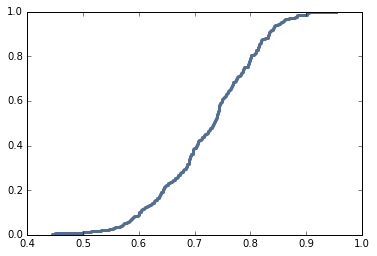

In [21]:
thinkplot.Cdf(predictive.Marginal(0).MakeCdf())
predictive.Marginal(0).Mean()

And then pull out the posterior predictive marginal distribution of P(B|A), with the posterior predictive mean

0.829444986890162

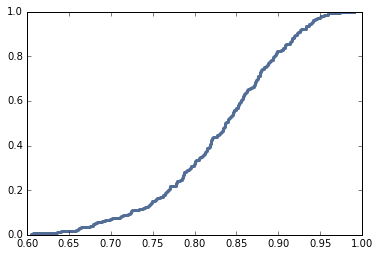

In [22]:
thinkplot.Cdf(predictive.Marginal(1).MakeCdf())
predictive.Marginal(1).Mean()

We don't really care about the posterior distributions of the parameters, but it's good to take a look and make sure they are not crazy.

The following function takes μ and Σ and unpacks them into a tuple of 5 parameters:

In [23]:
def unpack(μ, Σ):
    μ_a = μ[0]
    μ_b = μ[1]
    σ_a = np.sqrt(Σ[0][0])
    σ_b = np.sqrt(Σ[1][1])
    ρ = Σ[0][1] / σ_a / σ_b
    return μ_a, μ_b, σ_a, σ_b, ρ

So we can iterate through the posterior distribution and make a joint posterior distribution of the parameters:

In [24]:
def make_marginals(suite):
    joint = thinkbayes2.Joint()
    for params, prob in suite.Items():
        t = unpack(params.μ, params.Σ)
        joint[t] = prob
    return joint

marginals = make_marginals(suite)

And here are the posterior marginal distributions for `μ_a` and `μ_b`

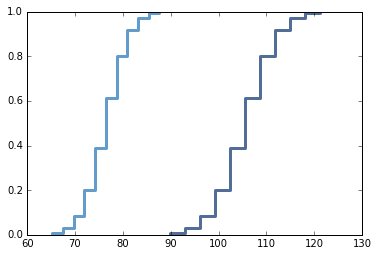

In [25]:
thinkplot.Cdf(marginals.Marginal(0).MakeCdf())
thinkplot.Cdf(marginals.Marginal(1).MakeCdf());

And here are the posterior marginal distributions for `σ_a` and `σ_b`

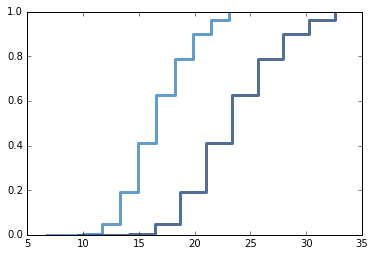

In [26]:
thinkplot.Cdf(marginals.Marginal(2).MakeCdf())
thinkplot.Cdf(marginals.Marginal(3).MakeCdf());

Finally, the posterior marginal distribution for the correlation coefficient, `ρ`

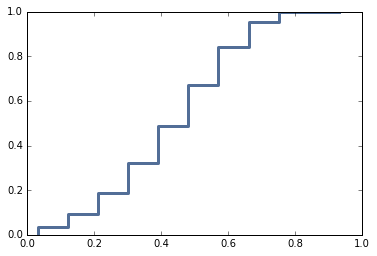

In [27]:
thinkplot.Cdf(marginals.Marginal(4).MakeCdf());

You can ignore everything after this, which is my development code and some checks.

In [28]:
raise Exception("YouShallNotPass")

Exception: YouShallNotPass

In [ ]:
def estimate(X):
    return X.mean(axis=1), np.cov(X)

In [ ]:
estimate(generate(xbar, S, n).transpose())

In [ ]:
def z_prime(r):
    return 0.5 * np.log((1+r) / (1-r))

def sampling_distributions(stats, cov, n):
    sig1, sig2, _ = std_rho(cov)
    
    array = np.zeros((len(stats), 8))
    for i, (xbar, S) in enumerate(stats):
        array[i, 0:2] = xbar
        s1, s2, r = std_rho(S)
        array[i, 2] = s1
        array[i, 3] = s2
        array[i, 4] = r
        array[i, 5] = (n-1) * S[0, 0] / cov[0, 0]
        array[i, 6] = (n-1) * S[1, 1] / cov[1, 1]
        array[i, 7] = z_prime(r)
    return array

dists = sampling_distributions(stats, cov, n)

In [ ]:
cdf0 = thinkbayes2.Cdf(dists[:, 0])
cdf1 = thinkbayes2.Cdf(dists[:, 1])
thinkplot.Cdfs([cdf0, cdf1])

In [ ]:
cdf2 = thinkbayes2.Cdf(dists[:, 2])
cdf3 = thinkbayes2.Cdf(dists[:, 3])
thinkplot.Cdfs([cdf2, cdf3])

In [ ]:
cdf4 = thinkbayes2.Cdf(dists[:, 4])
thinkplot.Cdfs([cdf4])

In [ ]:
cdf5 = thinkbayes2.Cdf(dists[:, 5])
cdf6 = thinkbayes2.Cdf(dists[:, 6])
thinkplot.Cdfs([cdf5, cdf6])

In [ ]:
cdf7 = thinkbayes2.Cdf(dists[:, 7])
thinkplot.Cdfs([cdf7])

In [ ]:
def sampling_dist_mean(i, mean, cov, cdf):
    sampling_dist = scipy.stats.norm(loc=mean[i], scale=np.sqrt(cov[i, i]/n))
    xs = cdf.xs
    ys = sampling_dist.cdf(xs)
    thinkplot.plot(xs, ys)
    thinkplot.Cdf(cdf)
    
sampling_dist_mean(0, mean, cov, cdf0)

In [ ]:
sampling_dist_mean(1, mean, cov, cdf1)

In [ ]:
def sampling_dist_std(i, mean, cov, cdf):
    sampling_dist = scipy.stats.chi2(df=n)
    xs = cdf.xs
    ys = sampling_dist.cdf(xs)
    thinkplot.plot(xs, ys)
    thinkplot.Cdf(cdf)
    
sampling_dist_std(5, mean, cov, cdf5)

In [ ]:
sampling_dist_std(6, mean, cov, cdf6)

In [ ]:
def sampling_dist_r(i, mean, cov, cdf):
    _, _, rho = std_rho(cov)
    sampling_dist = scipy.stats.norm(loc=z_prime(rho), scale=1/np.sqrt(n-3))
    xs = cdf.xs
    ys = sampling_dist.cdf(xs)
    thinkplot.plot(xs, ys)
    thinkplot.Cdf(cdf)
    
sampling_dist_r(7, mean, cov, cdf7)

In [ ]:
pdf_X = scipy.stats.multivariate_normal(mean, cov/n)

In [ ]:
pdf_X.pdf(mean) - pdf_X.pdf(mean-0.1) 

In [ ]:
def make_multi_norm_marginal(index, mean, cov, n):
    
    sigmas = std_rho(cov)
    width = 6 * sigmas[index] / np.sqrt(n)
    xs = np.linspace(mean[index]-width/2, mean[index]+width/2, 101)
    array = np.tile(mean, (len(xs), 1))
    array[:, index] = xs

    pdf_X = scipy.stats.multivariate_normal(mean, cov/n)
    ys = pdf_X.pdf(array)
    
    pmf = thinkbayes2.Pmf(dict(zip(xs, ys)))
    pmf.Normalize()
    return pmf

pmf = make_multi_norm_marginal(0, mean, cov, n)
thinkplot.Pdf(pmf)

In [ ]:
pmf = make_multi_norm_marginal(1, mean, cov, n)
thinkplot.Pdf(pmf)

In [ ]:
def generate_statistics(mean, cov, n, iters):
    return [estimate(generate(mean, cov, n)) for _ in range(iters)]

stats = generate_statistics(mean, cov, n, 1000)

In [ ]:
s0 = np.zeros(len(stats))
s1 = np.zeros(len(stats))

for i, (xbar, S) in enumerate(stats):
    sigmas = std_rho(S)
    s0[i] = sigmas[0]
    s1[i] = sigmas[1]

thinkplot.Scatter(s0, s1)

In [ ]:
s0 = np.zeros(len(stats))
s1 = np.zeros(len(stats))

for i, (xbar, S) in enumerate(stats):
    s0[i] = (n-1) * S[0][0]
    s1[i] = (n-1) * S[1][1]

thinkplot.Scatter(s0, s1)

In [ ]:
pdf_S = scipy.stats.wishart(df=n-1, scale=cov)
stats = pdf_S.rvs(1000)

s0 = np.zeros(len(stats))
s1 = np.zeros(len(stats))

for i, S in enumerate(stats):
    s0[i] = S[0][0]
    s1[i] = S[1][1]

thinkplot.Scatter(s0, s1)

In [ ]:
sigmas = std_rho(cov)
width = 6 * sigmas[0] / np.sqrt(2 * (n-1))
X = np.linspace(sigmas[0]-width/2, sigmas[0]+width/2, 101)

width = 6 * sigmas[1] / np.sqrt(2 * (n-1))
Y = np.linspace(sigmas[1]-width/2, sigmas[1]+width/2, 101)
Z = np.zeros((len(X), len(Y)))

pdf_S = scipy.stats.wishart(df=n-1, scale=cov)

for i, x in enumerate(X):
    for j, y in enumerate(Y):
        S = cov.copy()
        S[0, 0] = x**2
        S[1, 1] = y**2
        try:
            density = pdf_S.pdf((n-1) * S)
            Z[i, j] = density
        except:
            Z[i, j] = np.nan

In [ ]:
thinkplot.Scatter(s0, s1)
plt.contour(X, Y, Z)

In [ ]:
pmf_0 = thinkbayes2.Pmf()

for i, (xbar, S) in enumerate(stats):
    sig1, sig2, rho = std_rho(S)
    density = pdf_S.pdf((n-1) * S)
    pmf_0[sig1] += 1

In [ ]:
thinkplot.Cdf(pmf_0.MakeCdf())


In [ ]:
pdf_S = scipy.stats.wishart(df=n-1, scale=cov)

In [ ]:
pdf_S.pdf(cov)